# NP Predictive Analytics Assignment - Data Preparation
In this notebook we prepare the dataset for modeling

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.ma import polyfit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from data import dataset, dataprep

sns.set(style="whitegrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Data
Load data from CSV files, merging math and portuguese data as before.

In [2]:
# read data from CSV
col_dtypes = { col: "category" for col in dataset.cat_features + dataset.bin_features}
math_df = pd.read_csv(os.path.join("data", "Math.csv"), dtype=col_dtypes)
por_df = pd.read_csv(os.path.join("data", "Por.csv"), dtype=col_dtypes)

# merge data from math and portuguese data
math_df["subject"] = "math"
por_df["subject"] = "portuguese"
df = math_df.append(por_df)
df = df.reset_index()

### Feature Extraction: Final Grades
As suggested by the dataset's research paper, we bucket the raw scores into bins (A,B,C,D,F) in an attempt address data imbalance:
- $16 \le A \le 20$
- $14 \le B \le 15$
- $12 \le C \le 13$
- $10 \le D \le 11$
- $0 \le F \le 9$

In [3]:
df["G3Binned"] = pd.cut(df[dataset.target_var], [0, 9, 11, 13, 15, 20], 
                        right=True, include_lowest=True,
                        labels=["F", "D", "C", "B", "A"]).astype("category")

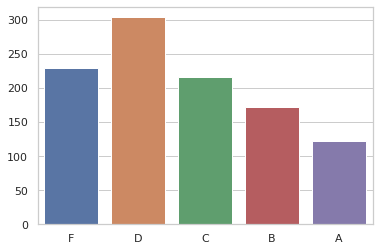

In [4]:
counts = df["G3Binned"].value_counts()
sns.barplot(counts.index, counts.values)

Observations:
- Binning has resolved some data imbalance.
- Resampling can be used to further combat data imbalance.

### Inputs and Outputs
Extract & separate the target output variable from the rest of the data
- final scores `G3` for regression task
- final grades `G3Binnned` for classification task


In [5]:
final_scores = df[dataprep.reg_target_var]
final_grades = df[dataprep.classify_target_var]
inputs_df = df.drop(columns=[dataprep.reg_target_var, 
                             dataprep.classify_target_var])

Encode categories into numeric integers

In [6]:
grade_mapping = list(enumerate(final_grades.cat.categories))
final_grades = final_grades.cat.codes
grade_mapping

[(0, 'F'), (1, 'D'), (2, 'C'), (3, 'B'), (4, 'A')]

### Hold Out Test Set
Set aside hold out test set for later cross validation
- use stratified sampling by final grade `G3Binned` to select examples for test set

> Since dataset is relatively small, we stratify the sample by the 
> final grade to limit the error introduced by sampling bias

In [7]:
# generate randomly split indexes that define split 
train_idxs, test_idxs = train_test_split(list(range(len(df))), 
                                         shuffle=True,
                                         stratify=final_grades,
                                         random_state=42,
                                         test_size=0.2)
print(f"train examples: {len(train_idxs)}, test examples: {len(test_idxs)}")

# split dataset based on indexes
train_in_df = inputs_df.iloc[train_idxs].copy()
test_in_df = inputs_df.iloc[test_idxs].copy()
train_scores, test_scores = final_scores[train_idxs], final_scores[test_idxs]
train_grades, test_grades = final_grades[train_idxs], final_grades[test_idxs]

train examples: 835, test examples: 209


## Feature Engineering
Hand engineer input features to produce better features

In [8]:
df = train_in_df.copy()

### Feature Combinations
Engineer new features by combining existing features

Engineered features:
- `alc` combines alchol consumption over the entire week, giving more weight to weekday alchol consumption.
- `gooutAlc` combines alcohol consumption with going out
- `ageAlc` - combine alcohol consumption with age
- `freeAlc` combines alchohol consumption with freetime
- `goFreeAlc` combines freetime with going out with alchol consumption
- `goFreeAlcAge`  combines freetime with going out with alchol consumption and age
- `studyAlc` - combines study 

<BarContainer object of 11 artists>

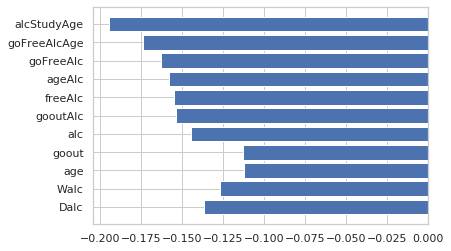

In [9]:
df["alc"]= df["Dalc"] + df["Walc"]
df["freeAlc"] = df["alc"] * df["freetime"]
df["gooutAlc"] = df["alc"] * df["goout"]
df["ageAlc"] = df["age"] * df["alc"]
df["goFreeAlc"] = df["goout"] * df["freetime"] * df["alc"]
df["goFreeAlcAge"] = df["goout"] * df["freetime"] * df["alc"] * df["age"] 
df["alcStudyAge"] = df["alc"] * df["age"] / df["studytime"] 

correlations = df.loc[:, ["Dalc", "Walc", "age", "goout", "alc", 
                          "gooutAlc", "freeAlc", "ageAlc", "goFreeAlc",
                          "goFreeAlcAge", "alcStudyAge"]].corrwith(train_scores)
plt.barh(correlations.index, correlations)

> `goFreeAlcAge` & `alcStudyAge` will replace the component features, except for `studytime`

Engineered features:
- `locVal` attempts to capture the value of the location of the student

Fedu          0.167806
Medu          0.216021
locVal        0.226561
traveltime   -0.103025
dtype: float64


<BarContainer object of 4 artists>

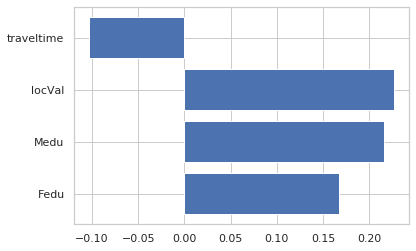

In [10]:
df["locVal"] = df["Medu"] / df["traveltime"]

correlations = df.loc[:, ["Fedu", "Medu",
                          "locVal", "traveltime"]].corrwith(train_scores)

print(correlations)
plt.barh(correlations.index, correlations)

> `locVal` will replace component features

- `failSqrt` square root of failures gives a slightly higher correlation. 
- `agePow` polynomial term of age give tiny bump to corelation

<BarContainer object of 4 artists>

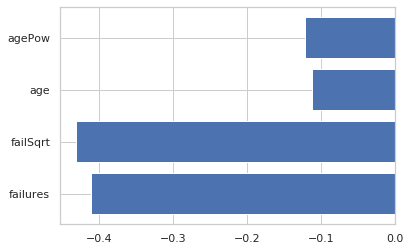

In [11]:
df["failSqrt"] = np.sqrt(df["failures"]) 
df["agePow"] = df["age"] ** 6.5

correlations = df.loc[:, ["failures", "failSqrt", 
                          "age", "agePow"]].corrwith(train_scores)
plt.barh(correlations.index, correlations)

> `failSqrt` would replace `failures` & `agePow` would replace `age`

## Data Preparation
In this section, we preprocess the data into a form suitable for modeling

### Split Dataset
Split up dataset to apply the different preprocessing steps required to 
prepare the data for different subtasks.

Split by:
- task - whether data is meant to perform classification or regression
- subset - part of the train or test subset of the data
- subject - from math of portuguese datasets

In [12]:
subjects = df["subject"].unique()
tasks = ["classify", "regression"]

# split train & test inputs by subject
input_dfs = {} #[task][subject_subset]
outputs = {} #[task][subject_subset]

for task in tasks:
    # create dict for task if  does not already exist 
    if not task in input_dfs: input_dfs[task] = {}
    if not task in outputs: outputs[task] = {}

    for subject in subjects:
        for subset, in_df, scores, grades in zip(["train", "test"], 
                                              [train_in_df, test_in_df],
                                              [train_scores, test_scores], 
                                              [train_grades, test_grades]):
            subset_id = f"{subject}_{subset}"
            input_dfs[task][subset_id] = in_df[in_df["subject"] == subject].copy()
            
            if task == "regression":
                outputs[task][subset_id] = scores[in_df["subject"] == subject]
            else:
                outputs[task][subset_id] = grades[in_df["subject"] == subject]


# print out no. of examples in each subset of the dataset
for task, task_dfs in input_dfs.items():
    print(f"======== task: {task} ========")
    for subset, in_df in task_dfs.items():
        print(f"{subset} no. of examples: {len(in_df)}")

======== task: classify ========
math_train no. of examples: 322
math_test no. of examples: 73
portuguese_train no. of examples: 513
portuguese_test no. of examples: 136
======== task: regression ========
math_train no. of examples: 322
math_test no. of examples: 73
portuguese_train no. of examples: 513
portuguese_test no. of examples: 136


### Build Data Pipeline
Build a Data Pipeline to preprocess the dataset:
1. Feature Transformer that adds features detailed in the <a href="#Feature-Engineering">Feature Engineering Section</a>
2. Transform features into form suitable for modeling
    - removes features (`famrel`,`health`,`absences`,`sex`,`Pstatus`,`famsup`)
      not useful to the prediction of the final grade `G3`.
    - numeric features - feature scale using Z-score transform
    - categorical features - feature extraction by one hot encoding
    - binary features - feature extraction by ordinal encoding

In [21]:
# build & return data pipeline
# has_features - whether to include feature extractor in data pipeline
def build_pipeline(has_features=True):
    # pipeline steps
    steps = []
   
    # feature extractor
    if has_features: steps += [("feat_extractor", dataprep.FeatureExtractor())]
    
    # dataset transformer
    cat_features = dataprep.cat_features if has_features else dataset.cat_features
    bin_features = dataprep.bin_features if has_features else dataset.bin_features
    num_features = dataprep.num_features if has_features else dataset.num_features
    
    steps += [ 
        ("df_transformer", ColumnTransformer([
            ("cat_pipeline", OneHotEncoder(), cat_features),
            ("bin_pipeline", OrdinalEncoder(), bin_features),
            ("num_pipeline", StandardScaler(), num_features)]
        ))
    ]
    
    return Pipeline(steps)

pipelines = {} # [task][subject]
for task in tasks:
    # create dict for task if not exist
    if not task in pipelines: pipelines[task] = {}
    for subject in subjects:
        pipelines[task][subject] = build_pipeline(has_features=True)

### Prepare Data with Data Pipeline
Use the built data pipelines to prepare input data for modeling

In [22]:
input_data = {}
for task in tasks:
    if not task in input_data: input_data[task] = {}
    for subject in subjects:
        # fit parameters of data pipeline
        pipelines[task][subject].fit(input_dfs[task][f"{subject}_train"])
        
        # prepare input data using data pipeline
        for subset in ["train", "test"]:
            subset_id = f"{subject}_{subset}"
            input_data[task][subset_id] = pipelines[task][subject].transform(
                input_dfs[task][subset_id])

### Data Imbalance
Extra Steps to process data for classification task to combat data imbalance:
- Perform random duplication of data example with a minority classes/label final grade to combat data imbalance.
> This is important as the data imbalance would cause the classifer
> to be biased towards the majority class/label instead of trying to
> predict all classes/labels accurately.

In [23]:
for subject in subjects:
    for subset in ["train", "test"]:
        subset_id = f"{subject}_{subset}"
        X = input_data["classify"][subset_id]
        y = outputs["classify"][subset_id]
        
        resampler = RandomOverSampler(random_state=42)
        X, y = resampler.fit_resample(X, y)
    
        input_data["classify"][subset_id] = X
        outputs["classify"][subset_id] = y

## Commit Data
Commit prepared data and objects used to prepare data

In [24]:
os.makedirs("build", exist_ok=True)
        
joblib.dump({
    "subjects": subjects,
    "tasks": tasks,
    "pipelines": pipelines,
    "input_data": input_data,
    "outputs": outputs,
    "grade_mapping": grade_mapping
}, os.path.join("build","dataprep.joblib"), compress=9)

['build/dataprep.joblib']